## Feature plots
**PT-BR: Extração de features**

### 📚 Libraries:
- Python libraries used for audio processing and features plots.
- [Click here]() to install dependencies.

**PT-BR: Bibliotecas**
- Bibliotecas python usadas para processamento de áudio e plotagens de gráficos.
- [Clique aqui]() para instalar as dependências.

In [1]:
import pandas as pd
import os
import numpy as np
import random
from scipy.io.wavfile import read
from scipy.fft import rfft, rfftfreq
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import librosa
import librosa.display as ld
from IPython.display import Audio
import pyloudnorm as pyln
from matplotlib import rcParams
from mosqito.utils import load
from mosqito.sq_metrics import loudness_zwst_perseg
from mosqito.sq_metrics import sharpness_din_st
from mosqito.sq_metrics import sharpness_din_perseg
from mosqito.sq_metrics import sharpness_din_from_loudness
from mosqito.sq_metrics import sharpness_din_freq
from mosqito.sq_metrics import loudness_zwst
from mosqito.sq_metrics import loudness_zwst_freq
from mosqito.sq_metrics import roughness_dw, roughness_dw_freq
from mosqito.sq_metrics import tnr_ecma_st
from mosqito.sq_metrics import pr_ecma_st

### 🔊 Defining functions for feature extraction:

- Assuming default sample rate for .wav of 44100 Hz
- Mean FFTs (Fast Fourier Transform)
- Max FFT’s (Fast Fourier Transform)
- Loudness
- Envelopes - five histograms of data
- Roughness
- Sharpness
- Spectrogram

**PT-BR: Definindo funções para extração de features**
- Média FFT’s (Transformada rápida de Fourier)
- Máxima FFT’s (Transformada rápida de Fourier)
- Sonoridade (loudness)
- Envelopes – cinco histogramas de dados
- Rugosidade
- Nitidez
- Espectrograma



In [ ]:
# definir frequencia max da fft
def maxfreq_fft(audio):
  len_audio = len(audio)
  fs = 44100
  SAMPLE_RATE = 1/fs
  tempo = np.linspace(0,len_audio/fs,len_audio)
  DURATION = tempo[len_audio-1]
  # Number of samples in normalized_tone
  N = int(DURATION / SAMPLE_RATE)
  yf = rfft(audio)
  xf = rfftfreq(N, SAMPLE_RATE)
  max_pos = np.array(np.abs(yf)).argmax()
  return max_pos

# loudness
def loud1(audio):
  # peak normalize audio to -1 dB
  peak_normalized_audio = pyln.normalize.peak(audio, -1.0)
  # measure the loudness first
  meter = pyln.Meter(44100) # create BS.1770 meter
  loudness = meter.integrated_loudness(audio)
  # loudness normalize audio to -12 dB LUFS
  loudness_normalized_audio = pyln.normalize.loudness(audio, loudness, -12.0)
  return loudness_normalized_audio

# espectrograma
def spect(audio):
  fs = 44100
  f, t, Sxx = signal.spectrogram(audio, fs)
  ind = np.unravel_index(np.argmax(Sxx, axis=None), Sxx.shape)
  feature3 = ind[1]/len(t)
  return feature3

#M. Glesser, S. Wanty, K. Degrendele, J. L. Besnerais, and S. Ni, “Perceived sound quality analysis of Electric
#Drive Units under different switching control strategies,” in 12th Aachen Acoustic Colloquium, Aachen, Nov. 2021.
#
# loudness
def loud2(audio):
  fs = 44100
  N, N_specific, bark_axis = loudness_zwst(audio, fs, field_type="free")
  return N

def sharp(audio):
  fs = 44100
  sharpness = sharpness_din_st(audio, fs, weighting="din")
  return sharpness

def roughness_(audio):
  fs = 44100
  # Compute multiple spectra along time
  r, r_spec, bark, time = roughness_dw(audio, fs, overlap=0)
  rough = sum(r)/len(audio)*10e5
  return rough

# tonalidade

def TNR_(audio):
  fs = 44100
  # Tone-to-noise Ratio calculation
  t_tnr, tnr, prom, tones_freq = tnr_ecma_st(audio, fs, prominence=True)
  print(t_tnr)
  print(tones_freq)
  return t_tnr, tones_freq

def PR_(audio):
  fs = 44100
  # Prominence Ratio calculation
  t_pr, pr, prom, tones_freq = pr_ecma_st(audio, fs, prominence=True)
  print(t_pr)
  print(tones_freq)
  return t_pr, tones_freq

In [ ]:
def envelope(audio, split=False):
    """
    Input :
    s: 1d-array, data signal from which to extract high and low envelopes
    dmin, dmax: int, optional, size of chunks, use this if the size of the input signal is too big
    split: bool, optional, if True, split the signal in half along its mean, might help to generate the envelope in some cases
    Output :
    lmin,lmax : high/low envelope idx of input signal s
    """
    dmin=274
    dmax=274
    fs = 44100
    len_audio = len(audio)
    tempo = np.linspace(0,len_audio/fs,len_audio)
     # locals min
    lmin = (np.diff(np.sign(np.diff(audio))) > 0).nonzero()[0] + 1
    # locals max
    lmax = (np.diff(np.sign(np.diff(audio))) < 0).nonzero()[0] + 1
    if split:
        # s_mid is zero if s centered around x-axis or more generally mean of signal
        s_mid = np.mean(audio)
        # pre-sorting of locals min based on relative position with respect to s_mid
        lmin = lmin[audio[lmin]<s_mid]
        # pre-sorting of local max based on relative position with respect to s_mid
        lmax = lmax[audio[lmax]>s_mid]
    # global min of dmin-chunks of locals min
    lmin = lmin[[i+np.argmin(audio[lmin[i:i+dmin]]) for i in range(0,len(lmin),dmin)]]
    # global max of dmax-chunks of locals max
    lmax = lmax[[i+np.argmax(audio[lmax[i:i+dmax]]) for i in range(0,len(lmax),dmax)]]
    LW = audio[lmin]
    UP = audio[lmax]
    return (UP-LW)/2

# definir histograma envelope

def hist_envelope(audio):
  ENV = envelope(audio)
  hist, bin_edges = np.histogram(ENV, bins=5)
  return hist, bin_edges




#### Sound signal of a cattle mooing in the morning before feeding
**PT-BR: Sinal sonoro de um gado mugindo pela manhã antes de se alimentar**

<ipython-input-24-27d304bf1703>:15: WavFileWarning: Chunk (non-data) not understood, skipping it.
  input_data = read(str(57) + "_pm_manha_290622.wav")


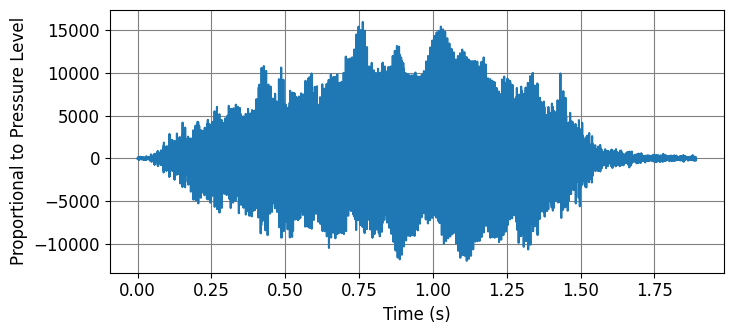

In [ ]:
fs = 44100

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.rcParams['font.size'] = '12'
mpl.rcParams['grid.color'] = 'black'

input_data = read(str(57) + "_pm_manha_290622.wav")
audio = input_data[1]
# salvar os dois arquivos audios
audio1 = audio[:,0]
audio2 = audio[:,1]

len_audio = len(audio1)
#print('len_audio = ', len_audio)

# definir vetor tempo
tempo = np.linspace(0,len_audio/fs,len_audio)
len_tempo = len(tempo)
#print('tempo = ', len_tempo)
plt.plot(tempo,audio1)
#plt.plot(tempo,audio2)
plt.ylabel("Proportional to Pressure Level")
plt.xlabel("Time (s)")
plt.grid(c='gray')
plt.show()

#### The absolute value of sound signal's FFT of a cattle mooing in the morning before feeding
**PT-BR: O valor absoluto da FFT do sinal sonoro de um gado mugindo pela manhã antes de se alimentar.**

Duration =  1.8915192743764173
N =  83416


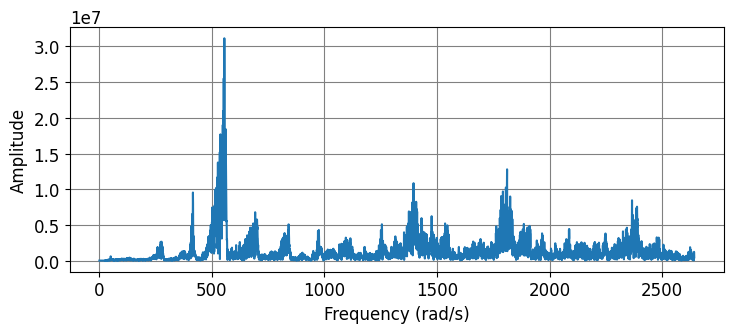

Maximum Freq:  555.1093315431092
max_freq =  555.1093315431092


In [ ]:
from scipy.fft import rfft, rfftfreq

SAMPLE_RATE = 1/fs
DURATION = tempo[len_audio-1]
print('Duration = ', DURATION)

# Number of samples in normalized_tone
N = int(DURATION / SAMPLE_RATE)
print('N = ', N)

yf = rfft(audio1)
xf = rfftfreq(N, SAMPLE_RATE)

plt.plot(xf[0:5000], np.abs(yf)[0:5000])
plt.ylabel("Amplitude")
plt.xlabel("Frequency (rad/s)")
plt.grid(c='gray')
plt.show()

max_pos = np.array(np.abs(yf)).argmax()
print("Maximum Freq: ", xf[max_pos])

mf1 = maxfreq_fft(audio1)
print('max_freq = ', xf[mf])



len_freq =  1025
max_freq =  555.1093315431092


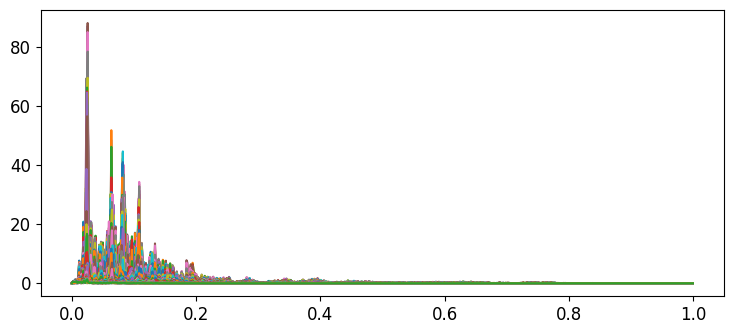

In [ ]:
caminho_completo = os.path.join("/content/drive/My Drive/Projeto ESALQ/features_and_augmentation/banco_de_dados/bezerro_julho/manha/pm_manha_julho_aumentado", "57_pm_manha_290622.wav")
audio, sr = librosa.load(caminho_completo, sr=48000)
frequencias = np.abs(librosa.core.stft(audio))
media_frequencias = np.mean(frequencias)
len_freq = len(frequencias)
print('len_freq = ', len_freq)

mf = maxfreq_fft(audio)
print('max_freq = ', xf[mf])
x_freq = np.linspace(0,1,len_freq)
plt.plot(x_freq,frequencias)
plt.show()


#### The absolute value of sound signal's FFT of a cattle mooing in the morning before feeding
**PT-BR: O valor absoluto da FFT do sinal sonoro de um gado mugindo pela manhã antes de se alimentar**

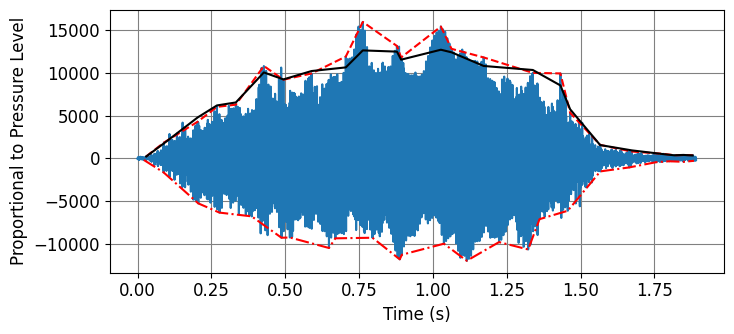

In [ ]:
def hl_envelopes_idx(s, dmin=1, dmax=1, split=False):
    """
    Input :
    s: 1d-array, data signal from which to extract high and low envelopes
    dmin, dmax: int, optional, size of chunks, use this if the size of the input signal is too big
    split: bool, optional, if True, split the signal in half along its mean, might help to generate the envelope in some cases
    Output :
    lmin,lmax : high/low envelope idx of input signal s
    """

    # locals min
    lmin = (np.diff(np.sign(np.diff(s))) > 0).nonzero()[0] + 1
    # locals max
    lmax = (np.diff(np.sign(np.diff(s))) < 0).nonzero()[0] + 1

    if split:
        # s_mid is zero if s centered around x-axis or more generally mean of signal
        s_mid = np.mean(s)
        # pre-sorting of locals min based on relative position with respect to s_mid
        lmin = lmin[s[lmin]<s_mid]
        # pre-sorting of local max based on relative position with respect to s_mid
        lmax = lmax[s[lmax]>s_mid]

    # global min of dmin-chunks of locals min
    lmin = lmin[[i+np.argmin(s[lmin[i:i+dmin]]) for i in range(0,len(lmin),dmin)]]
    # global max of dmax-chunks of locals max
    lmax = lmax[[i+np.argmax(s[lmax[i:i+dmax]]) for i in range(0,len(lmax),dmax)]]

    return lmin,lmax

lmin, lmax = hl_envelopes_idx(audio1,274,274)
LW = audio1[lmin]
UP = audio1[lmax]
ENVELOPE = (UP-LW)/2
# plot
plt.plot(tempo,audio1,label='signal')
plt.plot(tempo[lmin], LW, 'r-.', label='low')
plt.plot(tempo[lmax], UP, 'r--', label='high')
plt.plot(tempo[lmax],(UP-LW)/2,'k',label='envelope')
plt.ylabel("Proportional to Pressure Level")
plt.xlabel("Time (s)")
plt.grid(c='gray')
plt.show()

[8 1 3 3 9]
[  211.   2712.2  5213.4  7714.6 10215.8 12717. ]
[8. 1. 3. 3. 9.]


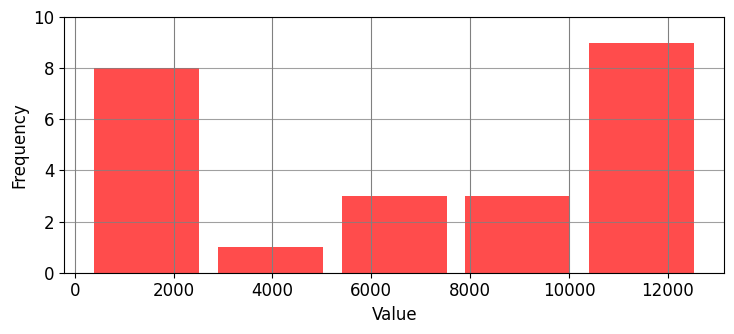

In [ ]:
hist, bin_edges = np.histogram(ENVELOPE, bins=5)
print(hist)
print(bin_edges)
n, bins, patches = plt.hist(x=ENVELOPE, bins=5, color='red',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(c='gray')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

print(n)